<a href="https://colab.research.google.com/github/chngdickson/depth_ai/blob/main/SSIM_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch  
import torch.nn as nn
import numpy as np
import math
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [9]:
!git clone https://github.com/chngdickson/depth_ai.git

Cloning into 'depth_ai'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 18 (delta 2), reused 17 (delta 1), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [10]:
def SSIM(x, y, C1=1e-4, C2=9e-4, kernel_size=3, stride=1):
    """
    Structural SIMilarity (SSIM) distance between two images.

    Parameters
    ----------
    x,y : torch.Tensor [B,3,H,W]
        Input images
    C1,C2 : float
        SSIM parameters
    kernel_size,stride : int
        Convolutional parameters

    Returns
    -------
    ssim : torch.Tensor [1]
        SSIM distance
    """
    pool2d = nn.AvgPool2d(kernel_size, stride=stride)
    refl = nn.ReflectionPad2d(1)

    x, y = refl(x), refl(y)
    mu_x = pool2d(x)
    mu_y = pool2d(y)

    mu_x_mu_y = mu_x * mu_y
    mu_x_sq = mu_x.pow(2)
    mu_y_sq = mu_y.pow(2)

    sigma_x = pool2d(x.pow(2)) - mu_x_sq
    sigma_y = pool2d(y.pow(2)) - mu_y_sq
    sigma_xy = pool2d(x * y) - mu_x_mu_y
    v1 = 2 * sigma_xy + C2
    v2 = sigma_x + sigma_y + C2

    # Where is the global ssim
    # I think AvgPool basically calculate the LOCAL SSIM
    # While Global SSIM is computer from the sigma's and the mu's. But we should test it out.
    
    # SSIM Nominator and denominator
    # SSIM_N = (2*mu_xy + C)* (2*sigmaxy+C2)
    # SSIM_D = (mu_x^2 + mu_y^2+C1) * (sigma_x^2 + sigma_y^2 + C2)
    ssim_n = (2 * mu_x_mu_y + C1) * v1
    ssim_d = (mu_x_sq + mu_y_sq + C1) * v2
    ssim = ssim_n / ssim_d

    return ssim

In [11]:
def ssim_to_img(ssim):
    arr = np.asarray(ssim[0])
    arr = arr.transpose((1,2,0))
    return arr

In [26]:
load_images = lambda x: np.asarray(Image.open(x).resize((480, 640)))
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

def read_img(path:str, shape:tuple=(480,640)):
  img = Image.open(path).resize(shape)
  img = np.asarray(img)
  return tensorify(img)


Img1 right


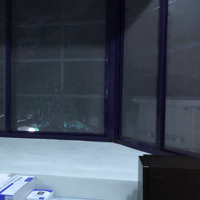

Img1 left


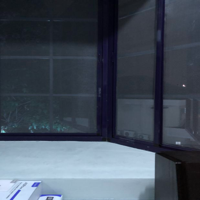

Img2 right


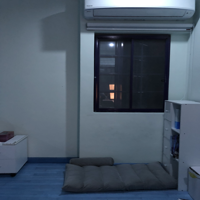

Img2 left


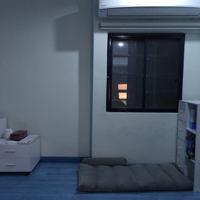

In [37]:
img1_left = Image.open("depth_ai/images/left.jpg").resize((200,200))
img1_right = Image.open("depth_ai/images/right.jpg").resize((200,200))
img2_left = Image.open("depth_ai/images/left2.jpg").resize((200,200))
img2_right = Image.open("depth_ai/images/right2.jpg").resize((200,200))
print("Img1 right")
cv2_imshow(np.asarray(img1_left))
print("Img1 left")
cv2_imshow(np.asarray(img1_right))
print("Img2 right")
cv2_imshow(np.asarray(img2_left))
print("Img2 left")
cv2_imshow(np.asarray(img2_right))

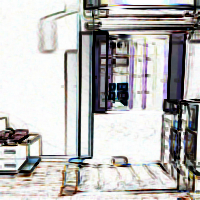

In [38]:
left = read_img("depth_ai/images/left2.jpg",(200,200))
right = read_img("depth_ai/images/right2.jpg",(200,200))

# Comparing Images Side by Side
similarity = SSIM(left,right)
ssim_img = ssim_to_img(similarity)
cv2_imshow(ssim_img*255)

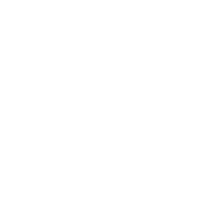

In [40]:
# Comparing SAME IMAGE
similarity = SSIM(right,right)
ssim_img = ssim_to_img(similarity)
cv2_imshow(ssim_img*255)

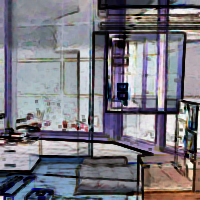

In [42]:
# Comparing Vastly Different Images
img1_left = read_img("depth_ai/images/left.jpg",(200,200))
img2_left = read_img("depth_ai/images/right2.jpg",(200,200))
similarity = SSIM(img1_left,img2_left)
ssim_img = ssim_to_img(similarity)
cv2_imshow(ssim_img*255)